In [6]:
ds

<xarray.Dataset> Size: 32GB
Dimensions:    (date: 405, latitude: 721, longitude: 1440)
Coordinates:
    number     int64 8B ...
  * date       (date) datetime64[ns] 3kB 1991-01-01 1991-02-01 ... 2024-09-01
  * latitude   (latitude) float64 6kB 90.0 89.75 89.5 ... -89.5 -89.75 -90.0
  * longitude  (longitude) float64 12kB 0.0 0.25 0.5 0.75 ... 359.2 359.5 359.8
    expver     (date) <U4 6kB ...
Data variables: (12/19)
    u10        (date, latitude, longitude) float32 2GB ...
    v10        (date, latitude, longitude) float32 2GB ...
    t2m        (date, latitude, longitude) float32 2GB ...
    sst        (date, latitude, longitude) float32 2GB ...
    sp         (date, latitude, longitude) float32 2GB ...
    tp         (date, latitude, longitude) float32 2GB ...
    ...         ...
    swvl3      (date, latitude, longitude) float32 2GB ...
    cvh        (date, latitude, longitude) float32 2GB ...
    lai_hv     (date, latitude, longitude) float32 2GB ...
    tvh        (date, latitude, longitude) float32 2GB ...
    z          (date, latitude, longitude) float32 2GB ...
    lsm        (date, latitude, longitude) float32 2GB ...
Attributes:
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2024-10-25T11:10 GRIB to CDM+CF via cfgrib-0.9.1...

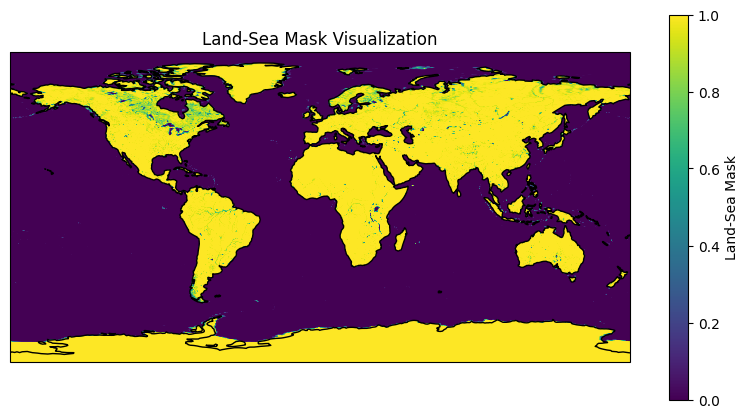

In [13]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import xarray as xr
import xarray as xr
import pandas as pd
from keplergl import KeplerGl

# Load the xarray dataset
ds = xr.open_dataset('/Users/adamprzychodni/Documents/Repos/ml-drought-forecasting/ml-modeling-pipeline/data/02_intermediate/preprocessed_data.nc')
# Select the first date in the dataset for visualization purposes (if temporal variation is needed)
ds = ds.sel(date=ds.date[0])  # Adjust this to select a different date if needed

# Extract land-sea mask
lsm = ds['lsm']

# Plot the Land-Sea Mask (lsm)
plt.figure(figsize=(10, 5))
ax = plt.axes(projection=ccrs.PlateCarree())
lsm.plot(
    ax=ax,
    transform=ccrs.PlateCarree(),
    cmap='viridis',  # Adjust color map as needed
    add_colorbar=True,
    cbar_kwargs={'label': 'Land-Sea Mask'}
)

# Adding map features
ax.coastlines()
ax.set_title("Land-Sea Mask Visualization")
plt.show()


In [3]:
import xarray as xr
import pandas as pd
from keplergl import KeplerGl

# Load the xarray dataset
ds = xr.open_dataset('/Users/adamprzychodni/Documents/Repos/ml-drought-forecasting/ml-modeling-pipeline/data/02_intermediate/preprocessed_data.nc')

ds_swvl3 = ds['swvl3']

# Select a specific date
ds_swvl1_date = ds_swvl3.sel(date='2024-09-01')  # Replace with the desired date

# Convert to DataFrame with longitude, latitude, and swvl3 values
df_swvl3 = ds_swvl3_date.to_dataframe().reset_index()

# Define bins and labels
bins = [-float('inf'), 0.1, 0.15, 0.2, 0.4, 0.5, 0.6, float('inf')]
labels = [1, 2, 3, 4, 5, 6, 7]

# Create 'category' column
df_swvl3['category'] = pd.cut(df_swvl3['swvl3'], bins=bins, labels=labels).astype(int)

# Adjust the KeplerGl configuration
config = {
    "version": "v1",
    "config": {
        "visState": {
            "layers": [
                {
                    "id": "swvl3_layer",
                    "type": "point",
                    "config": {
                        "dataId": "SWVL3 Data",
                        "label": "SWVL3 Data",
                        "color": [0, 255, 0],
                        "columns": {
                            "lat": "latitude",
                            "lng": "longitude",
                            "altitude": None
                        },
                        "isVisible": True,
                        "visConfig": {
                            "radius": 10,
                            "fixedRadius": False,
                            "opacity": 0.8,
                            "colorRange": {
                                "name": "Custom Colors",
                                "type": "ordinal",
                                "category": "Custom",
                                "colors": [
                                    "#FF0000",  # Category 1: red (swvl3 < 0.1)
                                    "#FF6347",  # Category 2: red-orange (0.1 ≤ swvl3 < 0.15)
                                    "#90EE90",  # Category 3: light green (0.15 ≤ swvl3 < 0.2)
                                    "#008000",  # Category 4: green (0.2 ≤ swvl3 < 0.4)
                                    "#006400",  # Category 5: dark green (0.4 ≤ swvl3 < 0.5)
                                    "#ADD8E6",  # Category 6: light blue (0.5 ≤ swvl3 < 0.6)
                                    "#00008B",  # Category 7: dark blue (swvl3 ≥ 0.6)
                                ]
                            },
                            "radiusRange": [0, 50],
                            "colorField": {"name": "category", "type": "integer"},
                            "colorScale": "ordinal"
                        }
                    },
                    "visualChannels": {
                        "colorField": {"name": "category", "type": "integer"},
                        "colorScale": "ordinal"
                    }
                }
            ]
        }
    }
}

# Initialize Kepler map with custom configuration
map_1 = KeplerGl(height=500, config=config)

# Add the SWVL3 Data
map_1.add_data(data=df_swvl3, name="SWVL3 Data")

# Display the map
map_1


In [24]:
import xarray as xr
import pandas as pd
from keplergl import KeplerGl

# Load the xarray dataset
ds = xr.open_dataset('/Users/adamprzychodni/Documents/Repos/ml-drought-forecasting/ml-modeling-pipeline/data/02_intermediate/preprocessed_data.nc')

# Apply the refined land-sea mask by setting values to NaN where lsm <= 0.5
masked_swvl3 = ds['swvl3'].where(ds['lsm'] > 0.5).rename("masked_swvl3")

# Select a specific date
masked_swvl3_date = masked_swvl3.sel(date='2024-09-01')  # Replace with the desired date

# Convert to DataFrame with longitude, latitude, and swvl3 values
df_swvl3 = masked_swvl3_date.to_dataframe().reset_index()

# Drop rows with NaN values to avoid plotting sea or non-land areas
df_swvl3 = df_swvl3.dropna(subset=['masked_swvl3'])

# Define bins and labels for categorizing soil water content
bins = [-float('inf'), 0.1, 0.15, 0.2, 0.4, 0.5, 0.6, float('inf')]
labels = [1, 2, 3, 4, 5, 6, 7]

# Create 'category' column based on the bins defined
df_swvl3['category'] = pd.cut(df_swvl3['masked_swvl3'], bins=bins, labels=labels).astype(int)

# Adjust the KeplerGl configuration to reflect the category colors
config = {
    "version": "v1",
    "config": {
        "visState": {
            "layers": [
                {
                    "id": "swvl3_layer",
                    "type": "point",
                    "config": {
                        "dataId": "SWVL3 Data",
                        "label": "SWVL3 Data",
                        "color": [0, 255, 0],
                        "columns": {
                            "lat": "latitude",
                            "lng": "longitude",
                            "altitude": None
                        },
                        "isVisible": True,
                        "visConfig": {
                            "radius": 10,
                            "fixedRadius": False,
                            "opacity": 0.8,
                            "colorRange": {
                                "name": "Custom Colors",
                                "type": "ordinal",
                                "category": "Custom",
                                "colors": [
                                    "#FF0000",  # Category 1: red (swvl3 < 0.1)
                                    "#FF6347",  # Category 2: red-orange (0.1 ≤ swvl3 < 0.15)
                                    "#90EE90",  # Category 3: light green (0.15 ≤ swvl3 < 0.2)
                                    "#008000",  # Category 4: green (0.2 ≤ swvl3 < 0.4)
                                    "#006400",  # Category 5: dark green (0.4 ≤ swvl3 < 0.5)
                                    "#ADD8E6",  # Category 6: light blue (0.5 ≤ swvl3 < 0.6)
                                    "#00008B",  # Category 7: dark blue (swvl3 ≥ 0.6)
                                ]
                            },
                            "radiusRange": [0, 50],
                            "colorField": {"name": "category", "type": "integer"},
                            "colorScale": "ordinal"
                        }
                    },
                    "visualChannels": {
                        "colorField": {"name": "category", "type": "integer"},
                        "colorScale": "ordinal"
                    }
                }
            ]
        }
    }
}

# Initialize Kepler map with custom configuration
map_1 = KeplerGl(height=500, config=config)

# Add the SWVL3 Data
map_1.add_data(data=df_swvl3, name="SWVL3 Data")

# Display the map
map_1


User Guide: https://docs.kepler.gl/docs/keplergl-jupyter


KeplerGl(config={'version': 'v1', 'config': {'visState': {'layers': [{'id': 'swvl3_layer', 'type': 'grid', 'co…

# Animation 

In [1]:
# import xarray as xr
# import pandas as pd
# from keplergl import KeplerGl
# from datetime import datetime

# # Load the xarray dataset
# ds = xr.open_dataset('/Users/adamprzychodni/Documents/Repos/ml-drought-forecasting/ml-modeling-pipeline/data/02_intermediate/preprocessed_data.nc')
# ds_swvl3 = ds['swvl3']

# # Select a date range (e.g., from '2024-07-01' to '2024-09-01')
# start_date = '2024-07-01'
# end_date = '2024-09-01'
# ds_swvl3_range = ds_swvl3.sel(date=slice(start_date, end_date))

# # Convert to DataFrame with date, longitude, latitude, and swvl3 values
# df_swvl3 = ds_swvl3_range.to_dataframe().reset_index()

# # Ensure 'date' column is in datetime format
# df_swvl3['date'] = pd.to_datetime(df_swvl3['date'])

# # Define bins and labels for categorization
# bins = [-float('inf'), 0.1, 0.15, 0.2, 0.4, 0.5, 0.6, float('inf')]
# labels = [1, 2, 3, 4, 5, 6, 7]

# # Create 'category' column based on 'swvl3' values
# df_swvl3['category'] = pd.cut(df_swvl3['swvl3'], bins=bins, labels=labels).astype(int)

# # Calculate the animation start time in milliseconds since epoch for July 1, 2024
# animation_start_date = datetime(2024, 7, 1)
# current_time_ms = int(animation_start_date.timestamp() * 1000)

# # Adjust the Kepler.gl configuration to include time playback
# config = {
#     "version": "v1",
#     "config": {
#         "visState": {
#             "filters": [
#                 {
#                     "id": "date_filter",
#                     "dataId": ["SWVL3 Data"],
#                     "name": ["date"],
#                     "type": "timeRange",
#                     "value": None,
#                     "enlarged": True,
#                     "plotType": "histogram",
#                     "animationWindow": "incremental",
#                     "yAxis": None
#                 }
#             ],
#             "layers": [
#                 {
#                     "id": "swvl3_layer",
#                     "type": "point",
#                     "config": {
#                         "dataId": "SWVL3 Data",
#                         "label": "SWVL3 Data",
#                         "color": [0, 255, 0],
#                         "columns": {
#                             "lat": "latitude",
#                             "lng": "longitude",
#                             "altitude": None
#                         },
#                         "isVisible": True,
#                         "visConfig": {
#                             "radius": 10,
#                             "fixedRadius": False,
#                             "opacity": 0.8,
#                             "colorRange": {
#                                 "name": "Custom Colors",
#                                 "type": "ordinal",
#                                 "category": "Custom",
#                                 "colors": [
#                                     "#FF0000",  # Category 1: red (swvl3 < 0.1)
#                                     "#FF6347",  # Category 2: red-orange (0.1 ≤ swvl3 < 0.15)
#                                     "#90EE90",  # Category 3: light green (0.15 ≤ swvl3 < 0.2)
#                                     "#008000",  # Category 4: green (0.2 ≤ swvl3 < 0.4)
#                                     "#006400",  # Category 5: dark green (0.4 ≤ swvl3 < 0.5)
#                                     "#ADD8E6",  # Category 6: light blue (0.5 ≤ swvl3 < 0.6)
#                                     "#00008B",  # Category 7: dark blue (swvl3 ≥ 0.6)
#                                 ]
#                             },
#                             "radiusRange": [0, 50],
#                             "colorField": {"name": "category", "type": "integer"},
#                             "colorScale": "ordinal"
#                         }
#                     },
#                     "visualChannels": {
#                         "colorField": {"name": "category", "type": "integer"},
#                         "colorScale": "ordinal",
#                         "timeField": {"name": "date", "type": "date"}
#                     }
#                 }
#             ],
#             "interactionConfig": {
#                 "tooltip": {
#                     "fieldsToShow": {
#                         "SWVL3 Data": [
#                             {"name": "date", "format": None},
#                             {"name": "latitude", "format": None},
#                             {"name": "longitude", "format": None},
#                             {"name": "swvl3", "format": None},
#                             {"name": "category", "format": None}
#                         ]
#                     },
#                     "enabled": True
#                 }
#             },
#             "layerBlending": "normal",
#             "splitMaps": [],
#             "animationConfig": {
#                 "currentTime": current_time_ms,
#                 "speed": 0.1  # Adjusted to match one month per second
#             }
#         }
#     }
# }

# # Initialize Kepler map with the custom configuration
# map_1 = KeplerGl(height=500, config=config)

# # Add the SWVL3 Data to the map
# map_1.add_data(data=df_swvl3, name="SWVL3 Data")

# # Display the map
# map_1


User Guide: https://docs.kepler.gl/docs/keplergl-jupyter


KeplerGl(config={'version': 'v1', 'config': {'visState': {'filters': [{'id': 'date_filter', 'dataId': ['SWVL3 …

In [34]:
import xarray as xr
import pandas as pd
from keplergl import KeplerGl
from datetime import datetime

# Load the xarray dataset
ds = xr.open_dataset('/Users/adamprzychodni/Documents/Repos/ml-drought-forecasting/ml-modeling-pipeline/data/01_raw/ERA5_monthly_averaged_data_on_single_levels.nc')

In [35]:
ds

<xarray.Dataset> Size: 44GB
Dimensions:    (date: 405, latitude: 721, longitude: 1440)
Coordinates:
    number     int64 8B ...
  * date       (date) int64 3kB 19910101 19910201 19910301 ... 20240801 20240901
  * latitude   (latitude) float64 6kB 90.0 89.75 89.5 ... -89.5 -89.75 -90.0
  * longitude  (longitude) float64 12kB 0.0 0.25 0.5 0.75 ... 359.2 359.5 359.8
    expver     (date) <U4 6kB ...
Data variables: (12/26)
    u10        (date, latitude, longitude) float32 2GB ...
    v10        (date, latitude, longitude) float32 2GB ...
    t2m        (date, latitude, longitude) float32 2GB ...
    sst        (date, latitude, longitude) float32 2GB ...
    sp         (date, latitude, longitude) float32 2GB ...
    tp         (date, latitude, longitude) float32 2GB ...
    ...         ...
    lai_lv     (date, latitude, longitude) float32 2GB ...
    cvl        (date, latitude, longitude) float32 2GB ...
    tvh        (date, latitude, longitude) float32 2GB ...
    tvl        (date, latitude, longitude) float32 2GB ...
    z          (date, latitude, longitude) float32 2GB ...
    lsm        (date, latitude, longitude) float32 2GB ...
Attributes:
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2024-10-25T11:10 GRIB to CDM+CF via cfgrib-0.9.1...

In [36]:
import xarray as xr
import pandas as pd

# 1. Convert 'date' coordinate to datetime
ds['date'] = pd.to_datetime(ds['date'].astype(str), format='%Y%m%d')

# Fill missing swvl1 values using a 3x3 window across both latitude and longitude
swvl1_filled = ds['swvl1'].rolling(latitude=3, longitude=3, center=True, min_periods=1).mean()

# Replace NaNs in swvl1 with the rolling mean calculated
ds['swvl1'] = ds['swvl1'].fillna(swvl1_filled)

# Calculate monthly climatology by averaging each month across all years (e.g., all Januaries, all Februaries)
climatology = ds['swvl1'].groupby('date.month').mean(dim='date')

# Calculate anomalies by subtracting the climatology (monthly mean) from each swvl1 value for that month
swvl1_anomalies = ds['swvl1'].groupby('date.month') - climatology

# Add anomalies as a new variable in the dataset
ds['swvl1_anomaly'] = swvl1_anomalies


In [37]:
ds

<xarray.Dataset> Size: 45GB
Dimensions:        (date: 405, latitude: 721, longitude: 1440)
Coordinates:
    number         int64 8B 0
  * date           (date) datetime64[ns] 3kB 1991-01-01 ... 2024-09-01
  * latitude       (latitude) float64 6kB 90.0 89.75 89.5 ... -89.5 -89.75 -90.0
  * longitude      (longitude) float64 12kB 0.0 0.25 0.5 ... 359.2 359.5 359.8
    expver         (date) <U4 6kB ...
    month          (date) int64 3kB 1 2 3 4 5 6 7 8 9 10 ... 1 2 3 4 5 6 7 8 9
Data variables: (12/27)
    u10            (date, latitude, longitude) float32 2GB ...
    v10            (date, latitude, longitude) float32 2GB ...
    t2m            (date, latitude, longitude) float32 2GB ...
    sst            (date, latitude, longitude) float32 2GB ...
    sp             (date, latitude, longitude) float32 2GB ...
    tp             (date, latitude, longitude) float32 2GB ...
    ...             ...
    cvl            (date, latitude, longitude) float32 2GB ...
    tvh            (date, latitude, longitude) float32 2GB ...
    tvl            (date, latitude, longitude) float32 2GB ...
    z              (date, latitude, longitude) float32 2GB ...
    lsm            (date, latitude, longitude) float32 2GB ...
    swvl1_anomaly  (date, latitude, longitude) float32 2GB -1.706e-06 ... 0.1191
Attributes:
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2024-10-25T11:10 GRIB to CDM+CF via cfgrib-0.9.1...

In [38]:
# Apply the land-sea mask by setting values to NaN where lsm <= 0.5, updating swvl1 in place
ds['swvl1_anomaly'] = ds['swvl1_anomaly'].where(ds['lsm'] > 0.5)

In [39]:
import xarray as xr
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
from typing import Optional, List
from datetime import datetime

def visualize_variable_on_map(
    dataset: xr.Dataset,
    variable: str,
    time_dim: str = 'date',
    lat_dim: str = 'latitude',
    lon_dim: str = 'longitude',
    plot_type: str = 'scatter_geo',
    downsample_factor: Optional[int] = 1,
    projection: str = 'natural earth',
    color_scale: str = 'Viridis',
    title: Optional[str] = None,
    animation_frame: Optional[str] = None,
    hover_precision: int = 2,
    custom_colorbar_title: Optional[str] = None,
    start_date: Optional[str] = None,
    end_date: Optional[str] = None,
    **kwargs
) -> go.Figure:
    """
    Universal function to visualize any variable from an xarray Dataset on a map with optional animation using Plotly.
    
    Parameters:
    - dataset (xr.Dataset): The xarray Dataset containing the data.
    - variable (str): The name of the variable to visualize.
    - time_dim (str): Name of the time dimension.
    - lat_dim (str): Name of the latitude dimension.
    - lon_dim (str): Name of the longitude dimension.
    - plot_type (str): Type of plot. Options include 'scatter_geo' and 'imshow'.
    - downsample_factor (int, optional): Factor by which to downsample spatial data.
    - projection (str): Map projection style for Plotly.
    - color_scale (str or list): Color scale for the plot.
    - title (str, optional): Title of the plot. Uses `GRIB_name` if available.
    - animation_frame (str, optional): Dimension to animate over.
    - hover_precision (int): Decimal precision for hover data.
    - custom_colorbar_title (str, optional): Custom title for the color bar. Uses `GRIB_units` if available.
    - start_date (str, optional): Start date for the data in ISO format (YYYY-MM-DD).
    - end_date (str, optional): End date for the data in ISO format (YYYY-MM-DD).
    - **kwargs: Additional keyword arguments passed to the Plotly plotting functions.
    
    Returns:
    - fig (plotly.graph_objs._figure.Figure): The Plotly figure object.
    """
    
    # Extract GRIB metadata for title and colorbar
    grib_name = dataset[variable].attrs.get("GRIB_name", variable)
    grib_units = dataset[variable].attrs.get("GRIB_units", "")
    
    # Use GRIB_name as title if not provided
    if not title:
        title = f"{grib_name}"
        if start_date or end_date:
            title += f" ({start_date or ''} to {end_date or ''})"
    
    # Set colorbar title
    colorbar_title = custom_colorbar_title if custom_colorbar_title else grib_units

    # Extract the DataArray
    da = dataset[variable]

    # Check if variable dimensions are correct
    for dim in [time_dim, lat_dim, lon_dim]:
        if dim not in da.dims:
            raise ValueError(f"Dimension '{dim}' not found in variable '{variable}'.")

    # Filter by date range if specified
    if start_date or end_date:
        if start_date:
            da = da.sel({time_dim: da[time_dim] >= pd.to_datetime(start_date)})
        if end_date:
            da = da.sel({time_dim: da[time_dim] <= pd.to_datetime(end_date)})

    # Downsample if required
    if downsample_factor > 1:
        da = da.coarsen({lat_dim: downsample_factor, lon_dim: downsample_factor}, boundary='trim').mean()

    # Plotting
    if plot_type == 'scatter_geo':
        df = da.to_dataframe().reset_index().dropna(subset=[variable])

        fig = px.scatter_geo(
            df,
            lat=lat_dim,
            lon=lon_dim,
            color=variable,
            animation_frame=animation_frame,
            projection=projection,
            color_continuous_scale=color_scale,
            title=title,
            labels={variable: grib_name},
            hover_data={variable: f":.{hover_precision}f"},
            **kwargs
        )

        fig.update_layout(
            coloraxis_colorbar=dict(
                title=colorbar_title,
                ticks="outside"
            )
        )
    
    elif plot_type == 'imshow':
        z = da.mean(dim=time_dim).values  # Aggregate over time dimension for a static plot
        if da[lat_dim][0] > da[lat_dim][-1]:
            z = z[::-1, :]
        
        fig = px.imshow(
            z,
            labels=dict(x=lon_dim, y=lat_dim, color=grib_name),
            x=da[lon_dim].values,
            y=da[lat_dim].values,
            color_continuous_scale=color_scale,
            title=title,
            **kwargs
        )
        
        fig.update_layout(
            coloraxis_colorbar=dict(
                title=colorbar_title,
                ticks="outside"
            )
        )
    else:
        raise ValueError(f"Plot type '{plot_type}' is not supported.")
    
    return fig


In [42]:
# %matplotlib inline

# variable = 'swvl1_anomaly'

# fig = visualize_variable_on_map(
#     dataset=ds,
#     variable=variable,
#     plot_type='scatter_geo',
#     animation_frame='date',
#     downsample_factor=12,
#     color_scale = 'Jet_r'
# )
# fig.show()

In [44]:
# import xarray as xr
# import pandas as pd
# import plotly.express as px
# import plotly.graph_objects as go
# from typing import Optional

# def visualize_variable_on_map(
#     dataset: xr.Dataset,
#     variable: str,
#     time_dim: str = 'date',
#     lat_dim: str = 'latitude',
#     lon_dim: str = 'longitude',
#     plot_type: str = 'scatter_geo',
#     downsample_factor: Optional[int] = 1,
#     projection: str = 'natural earth',
#     color_scale: str = 'Viridis',
#     title: Optional[str] = None,
#     animation_frame: Optional[str] = None,
#     hover_precision: int = 2,
#     custom_colorbar_title: Optional[str] = None,
#     start_date: Optional[str] = None,
#     end_date: Optional[str] = None,
#     **kwargs
# ) -> go.Figure:
#     """
#     Universal function to visualize any variable from an xarray Dataset on a map with optional animation using Plotly.
    
#     Parameters:
#     - dataset (xr.Dataset): The xarray Dataset containing the data.
#     - variable (str): The name of the variable to visualize.
#     - time_dim (str): Name of the time dimension.
#     - lat_dim (str): Name of the latitude dimension.
#     - lon_dim (str): Name of the longitude dimension.
#     - plot_type (str): Type of plot. Options include 'scatter_geo' and 'imshow'.
#     - downsample_factor (int, optional): Factor by which to downsample spatial data.
#     - projection (str): Map projection style for Plotly.
#     - color_scale (str or list): Color scale for the plot.
#     - title (str, optional): Title of the plot. Uses `GRIB_name` if available.
#     - animation_frame (str, optional): Dimension to animate over.
#     - hover_precision (int): Decimal precision for hover data.
#     - custom_colorbar_title (str, optional): Custom title for the color bar. Uses `GRIB_units` if available.
#     - start_date (str, optional): Start date for the data in ISO format (YYYY-MM-DD).
#     - end_date (str, optional): End date for the data in ISO format (YYYY-MM-DD).
#     - **kwargs: Additional keyword arguments passed to the Plotly plotting functions.
    
#     Returns:
#     - fig (plotly.graph_objs._figure.Figure): The Plotly figure object.
#     """
    
#     # Extract GRIB metadata for title and colorbar
#     grib_name = dataset[variable].attrs.get("GRIB_name", variable)
#     grib_units = dataset[variable].attrs.get("GRIB_units", "")
    
#     # Use GRIB_name as title if not provided
#     if not title:
#         title = f"{grib_name}"
#         if start_date or end_date:
#             title += f" ({start_date or ''} to {end_date or ''})"
    
#     # Set colorbar title
#     colorbar_title = custom_colorbar_title if custom_colorbar_title else grib_units

#     # Extract the DataArray
#     da = dataset[variable]

#     # Check if variable dimensions are correct
#     for dim in [time_dim, lat_dim, lon_dim]:
#         if dim not in da.dims:
#             raise ValueError(f"Dimension '{dim}' not found in variable '{variable}'.")

#     # Filter by date range if specified
#     if start_date or end_date:
#         if start_date:
#             da = da.sel({time_dim: da[time_dim] >= pd.to_datetime(start_date)})
#         if end_date:
#             da = da.sel({time_dim: da[time_dim] <= pd.to_datetime(end_date)})

#     # Downsample if required
#     if downsample_factor > 1:
#         da = da.coarsen({lat_dim: downsample_factor, lon_dim: downsample_factor}, boundary='trim').mean()

#     # Calculate the global min and max for the color scale
#     color_min = da.min().item()
#     color_max = da.max().item()

#     # Plotting
#     if plot_type == 'scatter_geo':
#         df = da.to_dataframe().reset_index().dropna(subset=[variable])

#         fig = px.scatter_geo(
#             df,
#             lat=lat_dim,
#             lon=lon_dim,
#             color=variable,
#             animation_frame=animation_frame,
#             projection=projection,
#             color_continuous_scale=color_scale,
#             title=title,
#             labels={variable: grib_name},
#             hover_data={variable: f":.{hover_precision}f"},
#             range_color=(color_min, color_max),  # Set constant color range
#             **kwargs
#         )

#         fig.update_layout(
#             coloraxis_colorbar=dict(
#                 title=colorbar_title,
#                 ticks="outside"
#             )
#         )
    
#     elif plot_type == 'imshow':
#         z = da.mean(dim=time_dim).values  # Aggregate over time dimension for a static plot
#         if da[lat_dim][0] > da[lat_dim][-1]:
#             z = z[::-1, :]
        
#         fig = px.imshow(
#             z,
#             labels=dict(x=lon_dim, y=lat_dim, color=grib_name),
#             x=da[lon_dim].values,
#             y=da[lat_dim].values,
#             color_continuous_scale=color_scale,
#             title=title,
#             range_color=(color_min, color_max),  # Set constant color range
#             **kwargs
#         )
        
#         fig.update_layout(
#             coloraxis_colorbar=dict(
#                 title=colorbar_title,
#                 ticks="outside"
#             )
#         )
#     else:
#         raise ValueError(f"Plot type '{plot_type}' is not supported.")
    
#     return fig

# %matplotlib inline

# variable = 'swvl1_anomaly'

# fig = visualize_variable_on_map(
#     dataset=ds,
#     variable=variable,
#     plot_type='scatter_geo',
#     animation_frame='date',
#     downsample_factor=12,
#     color_scale='Jet_r'
# )
# fig.show()


In [12]:
# import numpy as np

# import xarray as xr
# import pandas as pd
# import plotly.express as px
# import plotly.graph_objects as go
# from typing import Optional, List
# from datetime import datetime

# def visualize_variable_on_map(
#     dataset: xr.Dataset,
#     variable: str,
#     time_dim: str = 'date',
#     lat_dim: str = 'latitude',
#     lon_dim: str = 'longitude',
#     plot_type: str = 'scatter_geo',
#     downsample_factor: Optional[int] = 1,
#     projection: str = 'natural earth',
#     color_scale: List = None,
#     title: Optional[str] = None,
#     animation_frame: Optional[str] = None,
#     hover_precision: int = 2,
#     custom_colorbar_title: Optional[str] = None,
#     start_date: Optional[str] = None,
#     end_date: Optional[str] = None,
#     projection_scale: float = 1.5,  # New parameter to control projection scale
#     **kwargs
# ) -> go.Figure:
#     """
#     Universal function to visualize any variable from an xarray Dataset on a map with optional animation using Plotly.
#     """
    
#     # Extract GRIB metadata for title and colorbar
#     grib_name = dataset[variable].attrs.get("GRIB_name", variable)
#     grib_units = dataset[variable].attrs.get("GRIB_units", "")
    
#     if not title:
#         title = f"{grib_name}"
#         if start_date or end_date:
#             title += f" ({start_date or ''} to {end_date or ''})"
    
#     colorbar_title = custom_colorbar_title if custom_colorbar_title else grib_units

#     da = dataset[variable]

#     for dim in [time_dim, lat_dim, lon_dim]:
#         if dim not in da.dims:
#             raise ValueError(f"Dimension '{dim}' not found in variable '{variable}'.")

#     if start_date or end_date:
#         if start_date:
#             da = da.sel({time_dim: da[time_dim] >= pd.to_datetime(start_date)})
#         if end_date:
#             da = da.sel({time_dim: da[time_dim] <= pd.to_datetime(end_date)})

#     if downsample_factor > 1:
#         da = da.coarsen({lat_dim: downsample_factor, lon_dim: downsample_factor}, boundary='trim').mean()

#     df = da.to_dataframe().reset_index().dropna(subset=[variable])

#     # Apply custom binning for discrete color scales
#     bins = [0, 0.1, 0.15, 0.2, 0.4, 0.5, 0.6, np.inf]
#     labels = ["<0.1", "0.1-0.15", "0.15-0.2", "0.2-0.4", "0.4-0.5", "0.5-0.6", "≥0.6"]
#     df['swvl3_category'] = pd.cut(df[variable], bins=bins, labels=labels, include_lowest=True)
    
#     fig = px.scatter_geo(
#         df,
#         lat=lat_dim,
#         lon=lon_dim,
#         color='swvl3_category',  # Use the categorized variable
#         animation_frame=animation_frame,
#         projection=projection,
#         title=title,
#         labels={'swvl3_category': colorbar_title},
#         color_discrete_map={
#             "<0.1": "darkred",
#             "0.1-0.15": "red",
#             "0.15-0.2": "lightgreen",
#             "0.2-0.4": "green",
#             "0.4-0.5": "darkgreen",
#             "0.5-0.6": "lightblue",
#             "≥0.6": "blue"
#         },
#         **kwargs
#     )

#     # Increase the Earth's apparent size by adjusting the projection scale
#     fig.update_geos(
#         projection_scale=projection_scale  # Increase this value to make Earth appear larger
#     )

#     return fig

# # Example usage with dataset `ds`
# fig = visualize_variable_on_map(
#     dataset=ds,
#     variable='swvl3_anomaly',
#     plot_type='scatter_geo',
#     animation_frame='date',
#     downsample_factor=4,
#     projection_scale=5  # Adjust scale to make Earth bigger
# )
# fig.show()
